In [180]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

import torch
import torch_geometric as ptgeo

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx

from functions import \
run_GN, make_color_scale, gdisplay, run_and_draw,\
generate_training_data, graphs_loss_func,\
loss_batch, fit, randrange,\
gn_time_series

from training import fit

from gns import SingleDiffusionGN, EquationGN
from gnns import LinearGNN
from graph_compare import graph_compare, model_compare

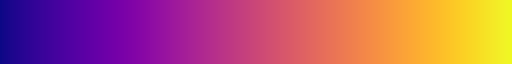

In [182]:
plt.cm.plasma

# Test/example

In [183]:
g_edge_index = torch.tensor(
    [[0, 1, 1, 2, 0, 2, 2, 3, 3, 4],
     [1, 0, 2, 1, 2, 0, 3, 2, 4, 3]],
    dtype=torch.long)

g_x = torch.tensor([[0.0], [0.7], [0.4], [0.9], [0]], dtype=torch.float)

g_data = ptgeo.data.Data(x=g_x, edge_index=g_edge_index)

diffusionGN = SingleDiffusionGN(0.1)

In [184]:
g_data.edge_index.shape[1]

10

In [185]:
g_data.x

tensor([[0.0000],
        [0.7000],
        [0.4000],
        [0.9000],
        [0.0000]])

In [186]:
diffusionGN.forward(g_data)

tensor([[0.1100],
        [0.6000],
        [0.4400],
        [0.7600],
        [0.0900]])

Iteration 0
sum: 2.0 / node values:
[[0.0], [0.699999988079071], [0.4000000059604645], [0.8999999761581421], [0.0]]


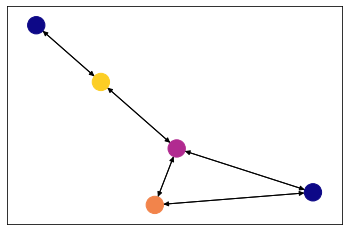

Iteration 1
sum: 2.0 / node values:
[[0.10999999940395355], [0.5999999642372131], [0.4399999976158142], [0.7599999904632568], [0.08999999612569809]]


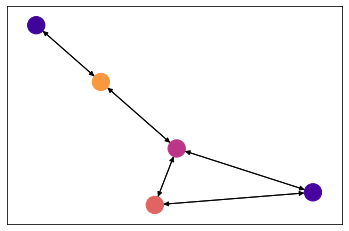

Iteration 2
sum: 2.0 / node values:
[[0.19200000166893005], [0.5349999666213989], [0.45499998331069946], [0.6610000133514404], [0.15700000524520874]]


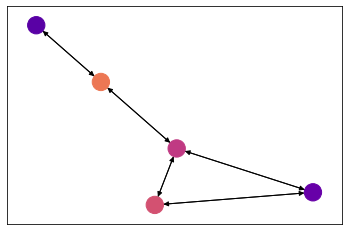

Iteration 3
sum: 1.9999998807907104 / node values:
[[0.2525999844074249], [0.4926999807357788], [0.45729997754096985], [0.5900000333786011], [0.20740000903606415]]


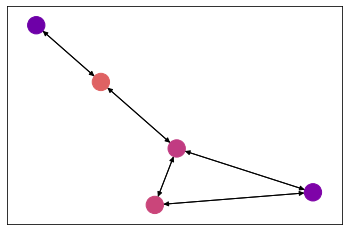

Iteration 4
sum: 2.0 / node values:
[[0.29707998037338257], [0.46514996886253357], [0.4536399841308594], [0.5384700298309326], [0.24566000699996948]]


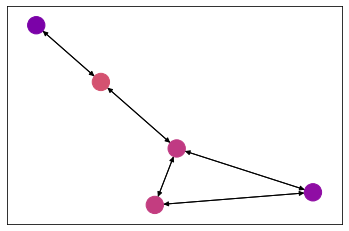

In [187]:
gfinal = run_and_draw(diffusionGN, g_data, 4, 1)

# Generate training data from the simulation

In [188]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [189]:
x_train, y_train = generate_training_data(diffusionGN)

In [190]:
print(f"Training items: {len(x_train)}")
assert len(x_train) == len(y_train)

Training items: 200


In [191]:
train_i = round(len(x_train) * 0.75)
train_x = x_train[0:train_i]
valid_x = x_train[train_i:]
train_y = y_train[0:train_i]
valid_y = y_train[train_i:]
batch_size = 10

In [192]:
#train_ds = TensorDataset(x_train, y_train)
#train_dl = DataLoader(train_ds, batch_size=5)
# ^error: graphs are not tensors

# Create a GNN

In [193]:
import torch.nn.functional as F

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LinearGNN(1).to(device)
next_graph = lambda gdata : ptgeo.data.Data(x = model(gdata),
                                            edge_index = gdata.edge_index)

## Examples

In [195]:
gn_time_steps = gn_time_series(diffusionGN, 4, g_data)
gn_time_steps

[Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10])]

In [196]:
gn_time_series(model, 4, g_data)

[Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10]),
 Data(x=[5, 1], edge_index=[2, 10])]

In [197]:
run_GN(model, 4, g_data)

Data(x=[5, 1], edge_index=[2, 10])

In [198]:
gn_after_running = run_GN(diffusionGN, 4, g_data)
gn_after_running

Data(x=[5, 1], edge_index=[2, 10])

In [199]:
gn_time_steps[-1].x, gn_after_running.x
# equal; run_GN is just a fast way of getting at the last thing;
# gn_time_series returns the entire time series

(tensor([[0.2971],
         [0.4651],
         [0.4536],
         [0.5385],
         [0.2457]]),
 tensor([[0.2971],
         [0.4651],
         [0.4536],
         [0.5385],
         [0.2457]]))

In [200]:
graphs_loss_func(model.forward, x_train[0:3], y_train[0:3])

tensor(1.6943, grad_fn=<AddBackward0>)

# Training

In [201]:
# run to reset model 

perf_history = []
lr_history = []
model = LinearGNN(1).to(device)
next_graph = lambda gdata : ptgeo.data.Data(x = model(gdata),
                                            edge_index = gdata.edge_index)


In [202]:
optim = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim,
        patience=60,
        cooldown=100,
        factor=0.2
    )

  0%|          | 0/300 [00:00<?, ?it/s]

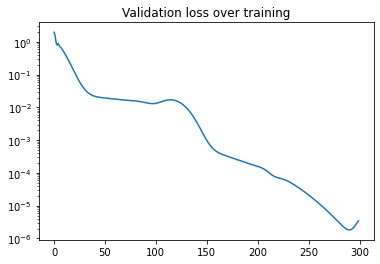

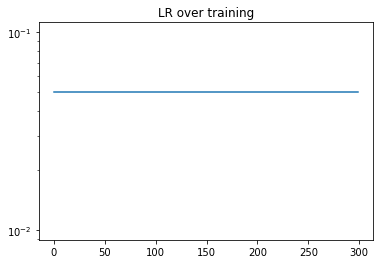

In [203]:
# rerun to continue training

(perf_history_add, lr_history_add) = fit(
    300, model, torch.nn.MSELoss(), optim, 
    (train_x, train_y),
    (valid_x, valid_y),
    lr_scheduler=scheduler,
    return_early_on_lr = 1e-10,
    progress_bar = True,
    return_lr = True
)
perf_history += perf_history_add
lr_history += lr_history_add

plt.title("Validation loss over training")
plt.plot(perf_history)
plt.yscale('log')
plt.show()

plt.title("LR over training")
plt.plot(lr_history)
plt.yscale('log')
plt.show()

In [204]:
list(model.m1.parameters())

[Parameter containing:
 tensor([[-0.3526,  0.3560]], requires_grad=True),
 Parameter containing:
 tensor([-0.0020], requires_grad=True)]

In [205]:
list(model.u1.parameters())

[Parameter containing:
 tensor([[0.9980, 0.2809]], requires_grad=True),
 Parameter containing:
 tensor([0.0009], requires_grad=True)]

### Predictions of GN

Iteration 0
sum: 2.0 / node values:
[[0.0], [0.699999988079071], [0.4000000059604645], [0.8999999761581421], [0.0]]


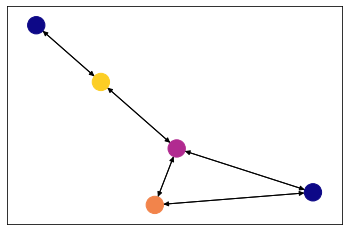

Iteration 1
sum: 2.0 / node values:
[[0.10999999940395355], [0.5999999642372131], [0.4399999976158142], [0.7599999904632568], [0.08999999612569809]]


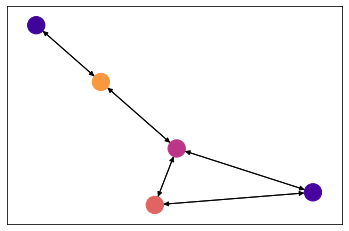

In [206]:
next_graph = run_and_draw(diffusionGN, g_data, 1, 1)

In [207]:
next_graph

Data(x=[5, 1], edge_index=[2, 10])

### Prediction of GNN

Iteration 0
sum: 2.0 / node values:
[[0.0], [0.699999988079071], [0.4000000059604645], [0.8999999761581421], [0.0]]


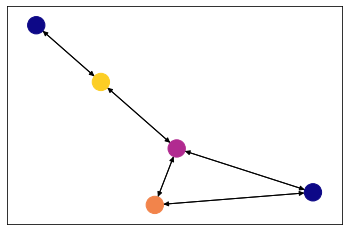

Iteration 1
sum: 1.9992551803588867 / node values:
[[0.10982559621334076], [0.5997364521026611], [0.43959736824035645], [0.7597130537033081], [0.0903826355934143]]


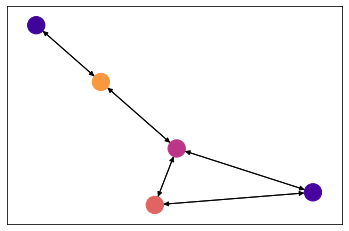

In [208]:
pred_next_graph = run_and_draw(model, g_data, 1, 1)

In [209]:
g_data.x

tensor([[0.0000],
        [0.7000],
        [0.4000],
        [0.9000],
        [0.0000]])

In [210]:
model.message(torch.tensor([[1.2]]), torch.tensor([[1.3]]))

tensor([[0.0376]], grad_fn=<AddmmBackward0>)

In [211]:
torch.abs(torch.tensor([[1, 2, -3]]))

tensor([[1, 2, 3]])

In [212]:
next_graph.x

tensor([[0.1100],
        [0.6000],
        [0.4400],
        [0.7600],
        [0.0900]])

In [213]:
pred_nxt_graph.x

tensor([[0.1100],
        [0.6000],
        [0.4400],
        [0.7600],
        [0.0900]])

In [214]:
graph_compare(nxt_graph, pred_nxt_graph, verbose=True, tol=0.06)

Differences tensor:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Max/avg/min distance: 0.0, 0.0, 0.0


True

Stats for 40 steps for node features:
Greatest relative difference: 102.43631601333618%
Average relative difference: 101.06657475233078%
Smallest relative difference: 100.01797676086426%
Greatest absolute difference: 0.009553581476211548
Average absolute difference: 0.004212094134709332
Smallest absolute difference: 6.389617919921875e-05%


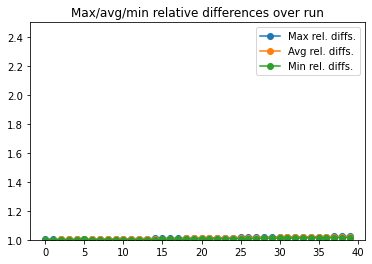

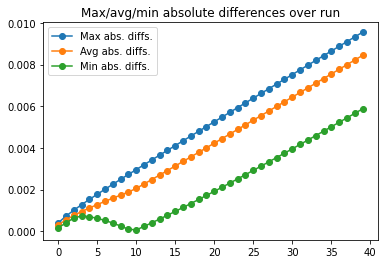

The model being tested finished the run outputting this graph:


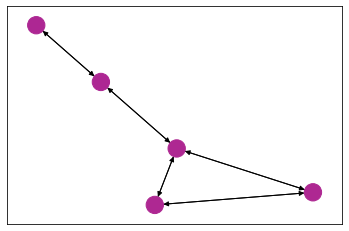

tensor([[0.3940],
        [0.3940],
        [0.3921],
        [0.3895],
        [0.3883]], grad_fn=<AddmmBackward0>)
The ground truth model finished the run outputting this graph:


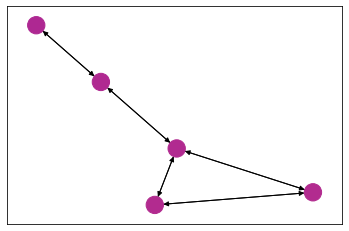

tensor([[0.4035],
        [0.4035],
        [0.4017],
        [0.3972],
        [0.3942]])


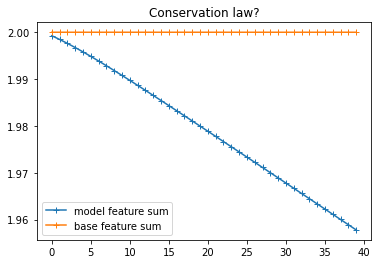

In [215]:
gm, g = model_compare(model, diffusionGN, g_data, iterations=40)

In [216]:
graph_compare(gm, g, tol=0.01, return_value = True)

(0.009553581476211548, 0.008441293612122536, 0.005873441696166992)

# Visualize functions

In [217]:

n = 1000

xs = torch.tensor(randrange(n, 0, 1)).view(n, 1).float()
ys = torch.tensor(randrange(n, 0, 1)).view(n, 1).float()
zs_1 = model.message(xs, ys)
zs_2 = model.update(xs, ys)

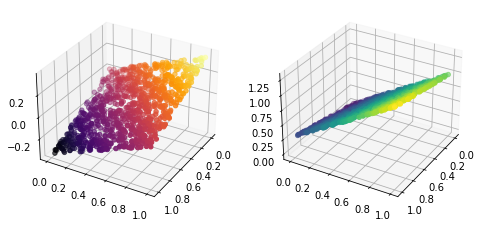

In [218]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

xsp = xs.view(-1).detach().numpy()
ysp = ys.view(-1).detach().numpy()
zs1p = zs_1.view(-1).detach().numpy()
zs2p = zs_2.view(-1).detach().numpy()

ax.scatter(xsp, ysp,
           zs1p,
           c=zs1p,
           cmap='inferno')

ax.view_init(30, 30)

ax2.scatter(xsp, ysp,
            zs2p,
            c=zs2p,
            cmap='viridis')

ax2.view_init(30, 30)

# Symbolic regression

In [219]:
from gplearn.genetic import SymbolicRegressor

In [220]:
input_vars = np.concatenate((xsp.reshape(-1,1),
                             ysp.reshape(-1,1)), axis=1)

In [221]:
input_vars

array([[0.6933855 , 0.9992272 ],
       [0.31427935, 0.387867  ],
       [0.68166417, 0.9885295 ],
       ...,
       [0.8615945 , 0.10735407],
       [0.6863592 , 0.7679736 ],
       [0.8794391 , 0.22261058]], dtype=float32)

In [222]:
output_vars1 = zs1p
output_vars2 = zs2p

In [223]:
message_sr = SymbolicRegressor(
    verbose=1,
    parsimony_coefficient=0.01
)
message_sr.fit(input_vars, output_vars1)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    37.77          6182.25        7        0.0852253              N/A     18.55s
   1    11.03         0.736973        5        0.0266962              N/A     12.12s
   2     5.92         0.310092        5        0.0266962              N/A     10.31s
   3     3.20          0.17057        5       0.00122885              N/A      9.28s
   4     4.71         0.147252        5       0.00122885              N/A      8.91s
   5     5.03         0.135739        5       0.00122885              N/A      8.33s
   6     5.05         0.115895        5       0.00122885              N/A      7.69s
   7     4.99         0.108433        5       0.00122885              N/A      7.04s
   8     4.98         0.246349        5       0.00122885              N/A  

SymbolicRegressor(parsimony_coefficient=0.01, verbose=1)

In [224]:
print(message_sr._program)

mul(0.357, sub(X1, X0))


In [225]:
update_sr = SymbolicRegressor(
    verbose=1,
    parsimony_coefficient=0.01
)
update_sr.fit(input_vars, output_vars2)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.55          2802.17        5        0.0901981              N/A     18.78s
   1     8.20           1.4848        5       0.00840453              N/A     11.12s
   2     5.03         0.432557        5       0.00840453              N/A     10.13s
   3     3.81         0.291479        5       0.00840453              N/A     12.82s
   4     4.98         0.342916        5       0.00840453              N/A      8.94s
   5     4.99         0.364167        5       0.00517596              N/A      8.21s
   6     4.89         0.374672        5       0.00517596              N/A      7.64s
   7     5.11         0.474558        5       0.00517596              N/A      7.17s
   8     4.99         0.354162        5       0.00517596              N/A  

SymbolicRegressor(parsimony_coefficient=0.01, verbose=1)

In [226]:
print(update_sr._program)

sub(X1, mul(X0, -0.271))


In [227]:
update_sr._program.execute(np.array([[1., 2.], [0, 0], [1, 0]]))

array([2.27071054, 0.        , 0.27071054])

The best way to learn about what these program attributes can do is to go to the [source code](https://github.com/trevorstephens/gplearn/blob/master/gplearn/_program.py)

# Interpretation of SR equations

For the message function, we have $X0 = x_t$ and $X1 = x_s$. Therefore, above we recovered
$$\text{message}(x_t, x_s) = 0.357 (x_s - x_t)$$

For the update function, we have $X0 = A$ (the aggregated message) and $X1 = x_t$. Therefore, above we have recovered
$$\text{update}(A, x_t) = x_t - (-0.271 A)$$

Combining these, we have for $x_t$ in the graph consisting of the single edge $x_s \to x_t$ that the next value $x_t^+$ of $x_t$ is
$$x_t^+ = \text{update}(\text{message}(x_t, x_s), x_t))\\
= \text{update}(0.357 (x_s - x_t), x_t)\\
= x_t + 0.271 (0.357 (x_s - x_t))\\
= x_t + 0.0967(x_s - x_t)$$

This compares to what the original equations give:
$$x_t^+ = \text{update}(\text{message}(x_t, x_s), x_t))\\
= \text{update}(0.1 (x_s - x_t), x_t)\\
= x_t + 0.1 (x_s - x_t)$$

# Numerical SR equation comparison

In [236]:
equationGN = EquationGN(
    message_sr._program.execute,
    update_sr._program.execute
)

In [237]:
equationGN.message_fn(torch.tensor([[1, 0], [1, 1]])).unsqueeze(dim=-1)

tensor([[-0.3573],
        [ 0.0000]], dtype=torch.float64)

In [238]:
model.message(torch.tensor([[0.], [1.]]), torch.tensor([[1.], [0.]]))

tensor([[ 0.3540],
        [-0.3546]], grad_fn=<AddmmBackward0>)

In [239]:
equationGN.message_fn(torch.cat([torch.tensor([[0.]]), torch.tensor([[1.]])], dim=1))

tensor([0.3573], dtype=torch.float64)

In [240]:
equationGN.message_fn(torch.tensor([[0.7000, 0.0000],
        [0.0000, 0.7000],
        [0.4000, 0.7000],
        [0.7000, 0.4000],
        [0.4000, 0.0000],
        [0.0000, 0.4000],
        [0.9000, 0.4000],
        [0.4000, 0.9000],
        [0.0000, 0.9000],
        [0.9000, 0.0000]]))

tensor([-0.2501,  0.2501,  0.1072, -0.1072, -0.1429,  0.1429, -0.1787,  0.1787,
         0.3216, -0.3216], dtype=torch.float64)

Stats for 40 steps for node features:
Greatest relative difference: 103.82349069313888%
Average relative difference: 101.31578948297113%
Smallest relative difference: 100.03529017694161%
Greatest absolute difference: 0.009779455980080842
Average absolute difference: 0.005028387307001881
Smallest absolute difference: 0.00013251007083997512%


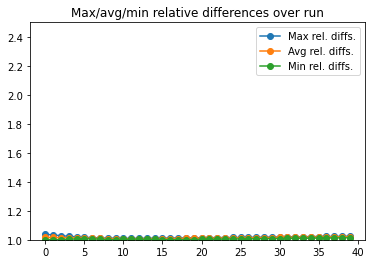

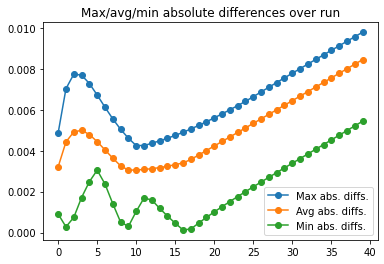

The model being tested finished the run outputting this graph:


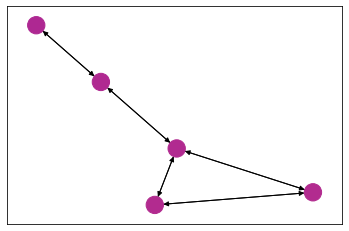

tensor([[0.4037],
        [0.4037],
        [0.4018],
        [0.3970],
        [0.3937]], dtype=torch.float64)
The ground truth model finished the run outputting this graph:


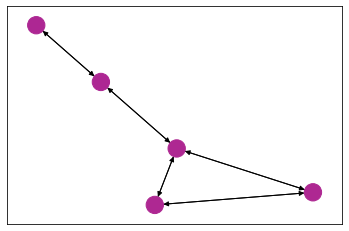

tensor([[0.3940],
        [0.3940],
        [0.3921],
        [0.3895],
        [0.3883]], grad_fn=<AddmmBackward0>)


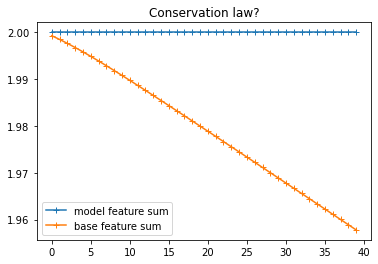

(Data(x=[5, 1], edge_index=[2, 10]), Data(x=[5, 1], edge_index=[2, 10]))

In [242]:
model_compare(equationGN, model, g_data, 40)

Stats for 40 steps for node features:
Greatest relative difference: 103.38397198839944%
Average relative difference: 100.36225238162875%
Smallest relative difference: 100.00343972038466%
Greatest absolute difference: 0.007062537110475664
Average absolute difference: 0.0012404054279118214
Smallest absolute difference: 1.3640132642933622e-05%


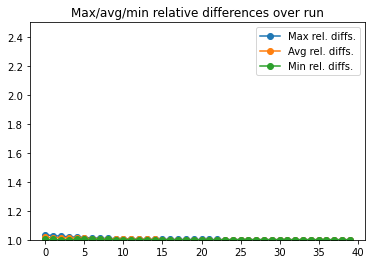

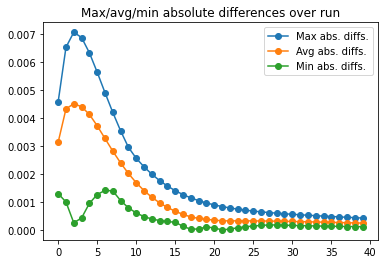

The model being tested finished the run outputting this graph:


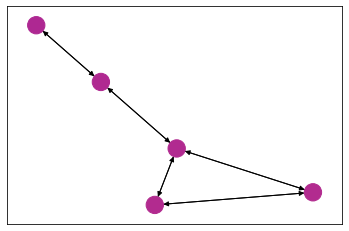

tensor([[0.4037],
        [0.4037],
        [0.4018],
        [0.3970],
        [0.3937]], dtype=torch.float64)
The ground truth model finished the run outputting this graph:


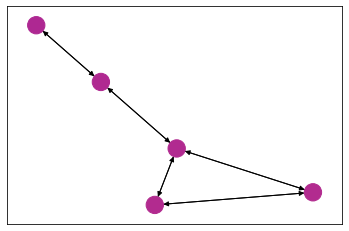

tensor([[0.4035],
        [0.4035],
        [0.4017],
        [0.3972],
        [0.3942]])


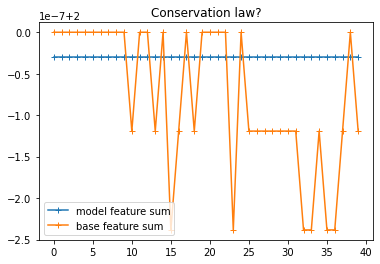

(Data(x=[5, 1], edge_index=[2, 10]), Data(x=[5, 1], edge_index=[2, 10]))

In [243]:
model_compare(equationGN, diffusionGN, g_data, 40)

# CONSERVATION LAW GRAPH ABOVE = ???

Iteration 0
sum: 2.0 / node values:
[[0.0], [0.699999988079071], [0.4000000059604645], [0.8999999761581421], [0.0]]


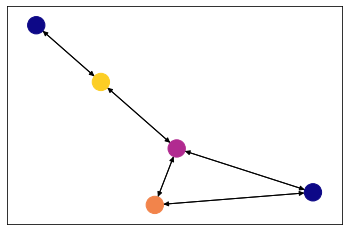

Iteration 3
sum: 1.9999999701976776 / node values:
[[0.24658012299260668], [0.496927206571226], [0.45703288499664263], [0.5970625704890767], [0.20239718514812557]]


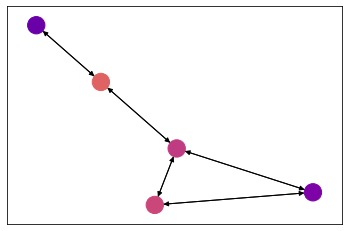

Data(x=[5, 1], edge_index=[2, 10])

In [234]:
run_and_draw(
    equationGN,
    g_data,
    4
)

Iteration 0
sum: 2.0 / node values:
[[0.0], [0.699999988079071], [0.4000000059604645], [0.8999999761581421], [0.0]]


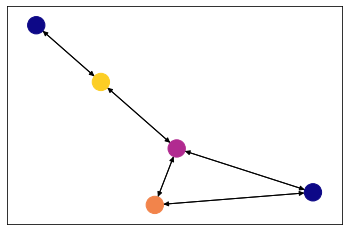

Iteration 3
sum: 1.9999998807907104 / node values:
[[0.2525999844074249], [0.4926999807357788], [0.45729997754096985], [0.5900000333786011], [0.20740000903606415]]


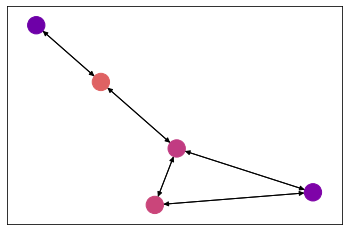

Data(x=[5, 1], edge_index=[2, 10])

In [235]:
run_and_draw(
    diffusionGN,
    g_data,
    4
)